In [11]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import xarray as xr

#from mikeio import Dfs0

import pandas as pd

#import funciones as fn

from keras.models import Sequential 
from keras.layers import AveragePooling2D, MaxPooling2D, LSTM, Dense,Dropout


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler


#wind
path1 = r"/Users/javier/Documents/Data/"      #set location of the files
#path2 ='C:/Users/56993/Documents/GitHub/Codigo_Javier_PRDW/'

names = ['download(1979-1988).nc',
         'download(1989-1999).nc',
         'download(2000-2009).nc',
         ]
files = [path1 + name for name in names]

dswind= xr.open_mfdataset(files)




#Waves usando mikeio
#path3 = r"E:/Data/"        #set location of the files
#dfs0 = Dfs0(path3 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912_check.dfs0")
#df0  = dfs0.read().to_dataframe()

#Waves usando csv
df0 = pd.read_csv('NCEP_Spectra2.csv',index_col='Unnamed: 0')



Desde = '1979-01-01 03:00:00'
Hasta = '2009-12-30 21:00:00'
desfase = 40

In [12]:
#Datos de Presión 

Valpo = dswind.sel(time=slice(Desde,  Hasta),longitude=slice(-130,-70),latitude=slice(-20,-80))


In [13]:
#Parametros de oleaje

Hm0 = np.array(df0[Desde: Hasta]['Hm0']).reshape(-1,1)[desfase:]
Tp = np.array(df0[Desde: Hasta]['Tp']).reshape(-1,1)[desfase:]
MD = np.array(df0[Desde: Hasta]['Mean Dir']).reshape(-1,1)[desfase:]
DSD =  np.array(df0[Desde: Hasta]['DSD']).reshape(-1,1)[desfase:]

In [15]:

#hace un avarage pooling y luego un reshape

def resize(Wind,i,flat=False):
    
    Wind = Wind.reshape(Wind.shape[0], Wind.shape[1], Wind.shape[2],1)

    
    Average_pool = AveragePooling2D(pool_size = int(10*i**0.5), strides= 5*i) #el poolsize y stride, están pensados para las futuras iteraciones

    model = Sequential([Average_pool]) 

    output = model.predict(Wind)    
    
    Wind = np.squeeze(output) 
    
    
    if flat:
        
        Wind = Wind.reshape(Wind.shape[0],-1)
    
    
    return Wind

In [16]:

def preparar_x(dswind, lotes = 10000, pooling = 7, flat = True):

    '''
    Función para poder crear un arreglo de datos que contenga todos los dato del dataserie,
    
    Es relevante, ya que se debe hacer por lotes para no exceder la capacidad de la RAM.
    
    lotes: int, corresponde al tamaño de cada lote a procesar mediante un avarage pooling
    
    pooling: int, densidad del avarage pooling.
    
    return, arreglo X correspondiente a la base de datos dswind completa con dimensión reducida

    '''


    Largototal = dswind.time.data.shape[0]

    j = lotes

    X = resize(np.array(dswind.msl.isel(time = slice(0,j)).data), pooling)

    
    for i in range(lotes*2,Largototal,lotes):
        
        windpart = resize(np.array(dswind.msl.isel(time = slice(j,i)).data), pooling)
        
        X = np.append(X,windpart, axis = 0)
        
        j = i
        
        print('Datos: ',i,'/',Largototal)
        
    windpart = resize(np.array(dswind.msl.isel(time = slice(j,Largototal)).data), pooling)

    X = np.append(X,windpart, axis = 0)
    
    if flat:
        
        X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
    
    return X

In [17]:
'''
Preparar los datos para poder ser ingresados a la red neuronal
'''

Wind2 = preparar_x(dswind.sel(time =slice(Desde,Hasta)), lotes = 5000, pooling = 6)

In [18]:
Wind2.shape

(90575, 256)

In [24]:
'''
Agrega una dimensión que contiene los desfases
flat, boolean para determinar si se hace reshape para mantener las dimensiones
'''

def desfasar(Var, desfase, flat = True):

    Var_d = []
 

    for t in range(desfase,Var.shape[0]):
        Var_d.append(Var[t-desfase:t+1,:])

    Var_d = np.array(Var_d)
  
    if flat:
        Var_d = Var_d.reshape(Var_d.shape[0],Var_d.shape[1]*Var_d.shape[2])

  
        
    return Var_d
    


In [25]:
#Preparamos los datos para modelar.

Wind_desf = desfasar(Wind2 ,desfase)

x_train, x_test = Wind_desf[:int(Wind_desf.shape[0]*0.8)], Wind_desf[int(Wind_desf.shape[0]*0.8):]


y_train_h, y_test_h =  Hm0[:int(Wind_desf.shape[0]*0.8)], Hm0[int(Wind_desf.shape[0]*0.8):]

y_train_t, y_test_t =  Tp[:int(Wind_desf.shape[0]*0.8)], Tp[int(Wind_desf.shape[0]*0.8):]

y_train_m, y_test_m =  MD[:int(Wind_desf.shape[0]*0.8)], MD[int(Wind_desf.shape[0]*0.8):]

y_train_d, y_test_d =  DSD[:int(Wind_desf.shape[0]*0.8)], DSD[int(Wind_desf.shape[0]*0.8):]



In [27]:
clf_h = linear_model.Ridge(alpha=.5,normalize=True)
clf_h = clf_h.fit(x_train,y_train_h) 

In [39]:
clf_t = linear_model.Ridge(alpha=.5,normalize=True)
clf_t = clf_t.fit(x_train,y_train_t) 

In [29]:
clf_m = linear_model.Ridge(alpha=.5,normalize=True)
clf_m = clf_m.fit(x_train,y_train_m) 

In [30]:
clf_d = linear_model.Ridge(alpha=.5,normalize=True)
clf_d = clf_d.fit(x_train,y_train_d) 

In [40]:
y_pred_h = clf_h.predict(x_test)

y_pred_t = clf_t.predict(x_test)

y_pred_m = clf_m.predict(x_test)

y_pred_d = clf_d.predict(x_test)

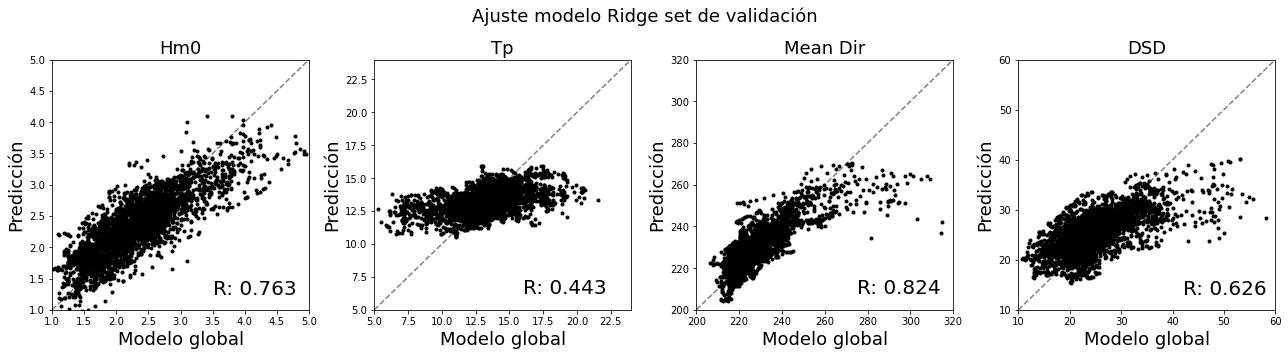

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(18,5))

fig.suptitle('Ajuste modelo Ridge set de validación',fontsize=18)


axs[0].set_title('Hm0',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(y_test_h[:3000],y_pred_h[:3000],'.',color='Black')
axs[0].set_xlabel('Modelo global',size=18)
axs[0].set_ylabel('Predicción',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(y_test_h.T,(y_pred_h).T)[0,1],3)),size=20)


axs[1].set_title('Tp',fontsize=18)
axs[1].plot([5,24],[5,24],'--',0.5,color='grey')
axs[1].plot(y_test_t[:3000],y_pred_t[:3000],'.',color='Black')
axs[1].set_xlabel('Modelo global',size=18)
axs[1].set_ylabel('Predicción',size=18)
axs[1].set_ylim(5,24)
axs[1].set_xlim(5,24)
axs[1].text(16,6.2,'R: '+str(np.round(np.corrcoef(y_test_t.T,(y_pred_t).T)[0,1],3)),size=20)

axs[2].set_title('Mean Dir',fontsize=18)
axs[2].plot([200,320],[200,320],'--',0.5,color='grey')
axs[2].plot(y_test_m[:3000],y_pred_m[:3000],'.',color='Black')
axs[2].set_xlabel('Modelo global',size=18)
axs[2].set_ylabel('Predicción',size=18)
axs[2].set_ylim(200,320)
axs[2].set_xlim(200,320)
axs[2].text(275,208,'R: '+str(np.round(np.corrcoef(y_test_m.T,(y_pred_m).T)[0,1],3)),size=20)

axs[3].set_title('DSD',fontsize=18)
axs[3].plot([10,60],[10,60],'--',0.5,color='grey')
axs[3].plot(y_test_d[:3000],y_pred_d[:3000],'.',color='Black')
axs[3].set_xlabel('Modelo global',size=18)
axs[3].set_ylabel('Predicción',size=18)
axs[3].set_ylim(10,60)
axs[3].set_xlim(10,60)
axs[3].text(42,13,'R: '+str(np.round(np.corrcoef(y_test_d.T,(y_pred_d).T)[0,1],3)),size=20)






fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("Ridge_prediccion_usando_40des_250var_Ps.png",dpi=300)

### Prueba del modelo Ridge en el espectro completo. 

### Modelar el espectro completo. 
Para esto debemos preparar el y_train e y_test usando los datos del espectro completo

In [47]:
path = '/Users/javier/Documents/Data/'
Espectro = xr.open_dataset(path + 'NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.nc')

In [48]:
Espectro

<xarray.Dataset>
Dimensions:              (Timestep: 90584, i: 36, j: 36)
Coordinates:
  * Timestep             (Timestep) datetime64[ns] 1979-01-01T03:00:00 ... 20...
  * i                    (i) float64 0.035 1.135 2.235 ... 36.34 37.44 38.54
  * j                    (j) float64 5.0 15.0 25.0 35.0 ... 335.0 345.0 355.0
    latitude             (i, j) float64 ...
    longitude            (i, j) float64 ...
    easting              (i, j) float64 ...
    northing             (i, j) float64 ...
Data variables:
    Wave energy density  (Timestep, i, j) float64 ...
Attributes:
    AxisUnit:    meter
    Projection:  Latitude:0.0_Longitude:0.0_Orientation:0.0_WkTString:NON-UTM

In [94]:

i = Espectro.i.data
j = Espectro.j.data
train_time = Espectro.Timestep.data[:-int(Wind_desf.shape[0]*0.1+desfase)]
test_time  = Espectro.Timestep.data[-int(Wind_desf.shape[0]*0.1+desfase):]

In [51]:
Y = np.array(Espectro['Wave energy density'].sel(Timestep = slice(Desde,Hasta)))

In [52]:
Y = Y.reshape(Y.shape[0],Y.shape[1]*Y.shape[2])

In [54]:

scx = MinMaxScaler()


Wind_desf = desfasar(scx.fit_transform(Wind) ,desfase,True)

Y_desf = Y[desfase:]

x_train = Wind_desf[:-int(Wind_desf.shape[0]*0.1)]

x_test = Wind_desf[-int(Wind_desf.shape[0]*0.1):]

y_train =  Y_desf[:-int(Wind_desf.shape[0]*0.1)]

y_test =  Y_desf[-int(Wind_desf.shape[0]*0.1):]


#x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])

#x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1])


#### Regresor Ridge

In [55]:
regresor = linear_model.Ridge(alpha=.5,normalize=True)
regresor = regresor.fit(x_train,y_train) 

In [56]:
y_test = y_test.reshape(y_test.shape[0],36,36)
y_train = y_train.reshape(y_train.shape[0],36,36)

In [89]:
#Regresor Ridge

y_pred_r_test = regresor.predict(x_test)
y_pred_r_test = y_pred_r_test.reshape(y_pred_r_test.shape[0],36,36)

y_pred_r_train = regresor.predict(x_train)
y_pred_r_train = y_pred_r_train.reshape(y_pred_r_train.shape[0],36,36)


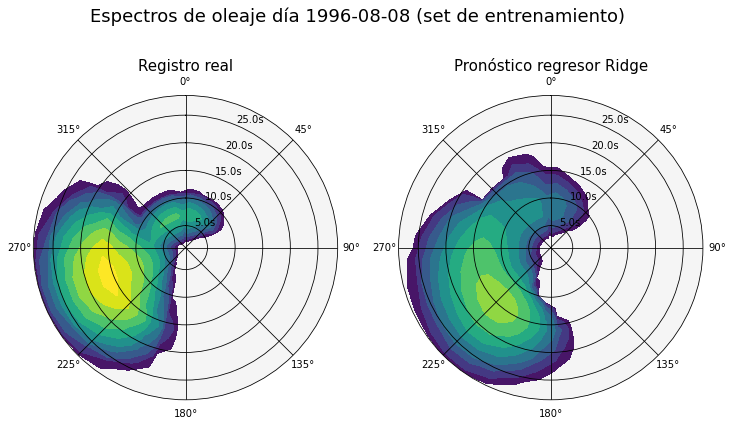

In [100]:
indice = 51434

levels = np.geomspace(0.01, 45, 10)


fig, axs = plt.subplots(1,2,figsize = (12,7), subplot_kw = dict(projection = 'polar'))#fig.suptitle('Vertically stacked subplots')

fig.suptitle('Espectros de oleaje día '+str(train_time[indice])[:10] + ' (set de entrenamiento)',fontsize=18)

plot_espectro(y_train,i,j,indice,axs[0],levels)
axs[0].set_title('Registro real',fontsize=15)

plot_espectro(np.round(y_pred_r_train,3),i,j,indice,axs[1],levels)
axs[1].set_title('Pronóstico regresor Ridge',fontsize=15)

#plot_espectro(np.round(y_pred_train,3),i,j,indice,axs[2],levels)
#axs[2].set_title('Pronóstico LSTM-FCL',fontsize=15)



fig.set_facecolor('w')

fig.savefig("Espectro_regresor",dpi=300)

In [68]:
from sklearn.metrics import mean_squared_error

MSE = []
for il in range(y_train.shape[0]):
    
    MSE.append(mean_squared_error(y_train[il], y_pred_r_train[il]))
MSE = np.array(MSE)

In [104]:
y_train.reshape(-1,36*36).shape

(81482, 1296)

In [108]:
Max_t = []
Max_p = []
for il in range(y_train.shape[0]):
    
    Max_t.append(np.max(y_train[il]))
    Max_p.append(np.max(y_pred_r_train[il]))
    
Max_t = np.array(Max_t)
Max_p = np.array(Max_p)

In [111]:
np.round(np.corrcoef(Max_t,Max_p)[0,1],4)

0.7544

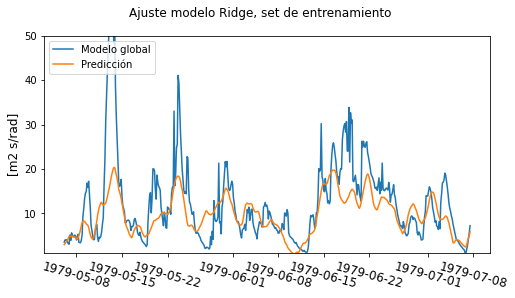

In [124]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

fig.suptitle('Ajuste modelo Ridge, set de entrenamiento')

axs.plot(train_time[1000:1500],Max_t[1000:1500],label='Modelo global')
axs.plot(train_time[1000:1500],Max_p[1000:1500],label='Predicción')
axs.xaxis.set_tick_params(rotation=-15, labelsize=12)
axs.set_ylabel('[m2 s/rad]',size=12)
axs.set_ylim(1,50)
axs.legend(loc=2)
fig.set_facecolor('w')
fig.savefig('Max', dpi=300)

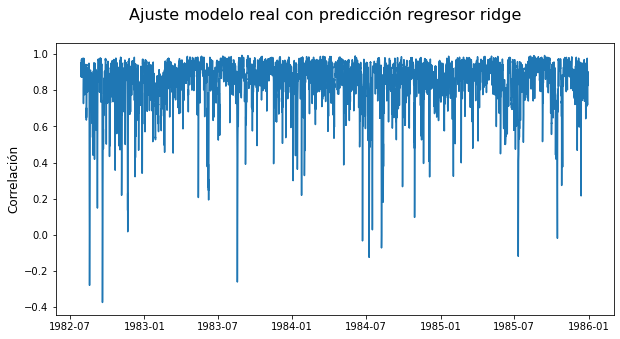

In [107]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(train_time[10434:20450],R[10434:20450])
fig.suptitle('Ajuste modelo real con predicción regresor ridge',fontsize=16)
ax.set_ylabel('Correlación',fontsize=12)
fig.set_facecolor('w')
fig.savefig('R', dpi=300)

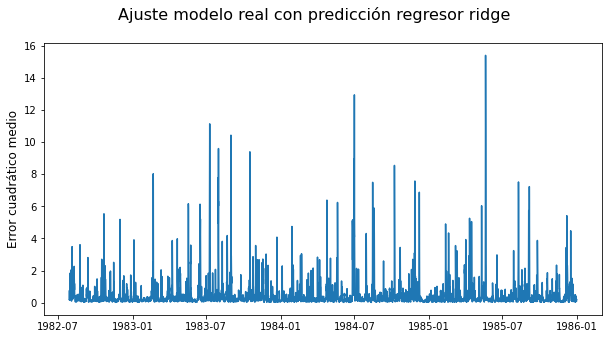

In [103]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(train_time[10434:20450],MSE[10434:20450])
fig.suptitle('Ajuste modelo real con predicción regresor ridge',fontsize=16)
ax.set_ylabel('Error cuadrático medio',fontsize=12)
fig.set_facecolor('w')
fig.savefig('MSE', dpi=300)


In [210]:
y_test2 = y_test.reshape(y_test.shape[0],36*36)
y_pred_test2 = y_pred_test.reshape(y_pred_test.shape[0],36*36)

In [215]:
Correlacion=[]
for i in range(y_test2.shape[1]):
    Correlacion.append(np.corrcoef(y_test2[:,i],y_pred_test2[:,i])[0,1])
Correlacion = np.array(Correlacion)
Correlacion = Correlacion.reshape(36,36)

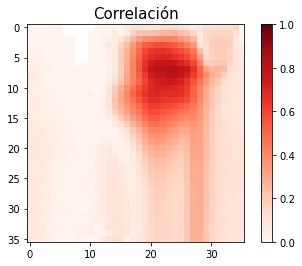

In [214]:
fig, axs = plt.subplots(1,1)

axs.imshow(Correlacion,cmap='Reds',vmin=0,vmax=1)
axs.set_title('Correlación',fontsize=15)
fig.colorbar(axs.imshow(Correlacion,cmap='Reds',vmin=0,vmax=1), shrink=1)

In [59]:
import funciones as fn

def plot_espectro(data,i,j,time,ax,levels,cbar=False):

    deltaf= i[1]-i[0]
    f=[]
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = pd.DataFrame(columns = j, index = [1/freq for freq in f], 
                        data = data[time,:,:])

    return fn.plot_spectra(df, item = None, tstep = None, 
                 figsize = (4,4), cmap = 'viridis', cbar = cbar, cbar_label = None, 
                 levels = levels, ax = ax, extend = 'both',
                 watermark = None, prdw_logo_path = None, 
                 prdw_logo_size = [0.69, 0.75, 0.15, 0.15], 
                 prdw_logo_alpha = 0.5, fig = None)
    